In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/poem-generation/poem.txt


In [2]:
import random  # Random number generator
import pickle  # Object serialization

import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization

import tensorflow.keras.utils as ku  # Keras utility functions
from wordcloud import WordCloud  # Word cloud generation
from sklearn.model_selection import train_test_split  # Data splitting

from tensorflow.keras.preprocessing.sequence import pad_sequences  # Sequence padding
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization  # Neural network layers
from tensorflow.keras.preprocessing.text import Tokenizer  # Text preprocessing
from tensorflow.keras.models import Sequential, load_model  # Neural network models
from tensorflow.keras.optimizers import Adam  # Optimization algorithms
from tensorflow.keras import regularizers  # Regularization techniques
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Callbacks for model training

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


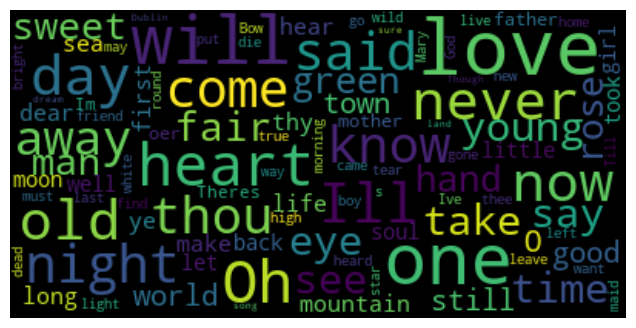

In [3]:
# Reading the text data file
data = open('/kaggle/input/poem-generation/poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [4]:
type(data)

str

In [5]:
data

'Stay, I said\nto the cut flowers.\nThey bowed\ntheir heads lower.\nStay, I said to the spider,\nwho fled.\nStay, leaf.\nIt reddened,\nembarrassed for me and itself.\nStay, I said to my body.\nIt sat as a dog does,\nobedient for a moment,\nsoon starting to tremble.\nStay, to the earth\nof riverine valley meadows,\nof fossiled escarpments,\nof limestone and sandstone.\nIt looked back\nwith a changing expression, in silence.\nStay, I said to my loves.\nEach answered,\nAlways.\nTwo sets\nof family stories,\none long and detailed,\nabout many centuries\nof island ancestors, all living\non the same tropical farm...\nThe other side of the family tells stories\nthat are brief and vague, about violence\nin the Ukraine, which Dad\'s parents\nhad to flee forever, leaving all their\nloved ones\nbehind.\nThey don\'t even know if anyone\nsurvived.\nWhen Mami tells her flowery tales of Cuba,\nshe fills the twining words with relatives.\nBut when I ask my\nUkrainian-Jewish-American grandma\nabout her

In [6]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [7]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 3807


In [12]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


In [13]:
input_sequences

array([[   0,    0,    0, ...,    0,  266,    3],
       [   0,    0,    0, ...,  266,    3,   59],
       [   0,    0,    0, ...,    0,    4,    1],
       ...,
       [   0,    0,    0, ..., 3807,   15,    4],
       [   0,    0,    0, ...,   15,    4,  203],
       [   0,    0,    0, ...,    4,  203,   85]], dtype=int32)

In [14]:
# predictors
input_sequences[:, :-1]

array([[   0,    0,    0, ...,    0,    0,  266],
       [   0,    0,    0, ...,    0,  266,    3],
       [   0,    0,    0, ...,    0,    0,    4],
       ...,
       [   0,    0,    0, ...,    8, 3807,   15],
       [   0,    0,    0, ..., 3807,   15,    4],
       [   0,    0,    0, ...,   15,    4,  203]], dtype=int32)

In [15]:
# label
input_sequences[:, -1]

array([  3,  59,   1, ...,   4, 203,  85], dtype=int32)

In [16]:
max_sequence_len

16

In [17]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
print(predictors.shape)
print(label.shape)

(16311, 15)
(16311, 3808)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(predictors, label, test_size=0.25, random_state=42)

In [22]:
sequence_len = predictors.shape[1]
sequence_len

15

In [23]:
def create_bi_lstm_model(total_words,sequence_len):
    """
    Creates a bidirectional LSTM model for text generation.

    Args:
        total_words (int): The total number of unique words in the vocabulary.
        sequence_len (int): The length of input sequences (number of tokens).

    Returns:
        keras.models.Sequential: The created bidirectional LSTM model.

    """
    model = Sequential()
    model.add(Embedding(input_dim=total_words,
                        output_dim=sequence_len,
                        input_length=sequence_len))
    
    model.add(Bidirectional(LSTM(units=150,return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=150,return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(LSTM(units=300))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(total_words+1/2, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(units=total_words,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics='accuracy')
    
    model.summary()
    return model

In [24]:
model = create_bi_lstm_model(total_words+1,sequence_len)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 15)            57120     
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          199200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 300)          541200    
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 15, 300)          1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                        

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=300,verbose=1,mode='max',restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=10,mode='max',factor=0.1,min_lr=0.001,verbose=1)
model_checkpoint = ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True,verbose=1)

history = model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=150,
          verbose=2,
          validation_data=(X_test,y_test),
          callbacks=[model_checkpoint,reduce_lr,early_stopping])

Epoch 1/150

Epoch 1: val_accuracy improved from -inf to 0.06130, saving model to checkpoint/
96/96 - 28s - loss: 12.9592 - accuracy: 0.0194 - val_loss: 10.6854 - val_accuracy: 0.0613 - lr: 0.0010 - 28s/epoch - 291ms/step
Epoch 2/150

Epoch 2: val_accuracy did not improve from 0.06130
96/96 - 5s - loss: 11.2731 - accuracy: 0.0276 - val_loss: 10.0166 - val_accuracy: 0.0319 - lr: 0.0010 - 5s/epoch - 50ms/step
Epoch 3/150

Epoch 3: val_accuracy did not improve from 0.06130
96/96 - 4s - loss: 10.6573 - accuracy: 0.0333 - val_loss: 9.9614 - val_accuracy: 0.0319 - lr: 0.0010 - 4s/epoch - 40ms/step
Epoch 4/150

Epoch 4: val_accuracy did not improve from 0.06130
96/96 - 3s - loss: 10.2697 - accuracy: 0.0390 - val_loss: 10.5892 - val_accuracy: 0.0042 - lr: 0.0010 - 3s/epoch - 33ms/step
Epoch 5/150

Epoch 5: val_accuracy did not improve from 0.06130
96/96 - 3s - loss: 9.7348 - accuracy: 0.0426 - val_loss: 10.9044 - val_accuracy: 0.0245 - lr: 0.0010 - 3s/epoch - 28ms/step
Epoch 6/150

Epoch 6: va

In [27]:
# Save training history
with open('training_history_bi_lstm.pickle', 'wb') as file:
    pickle.dump(history.history, file)

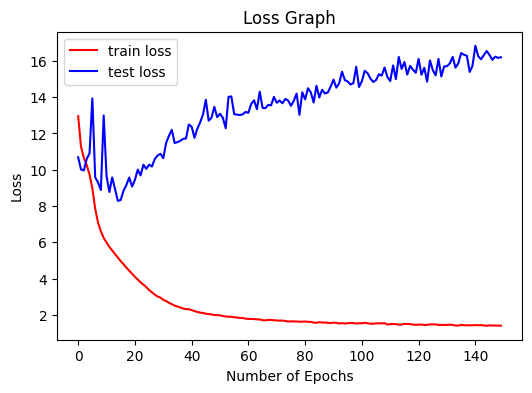

In [28]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

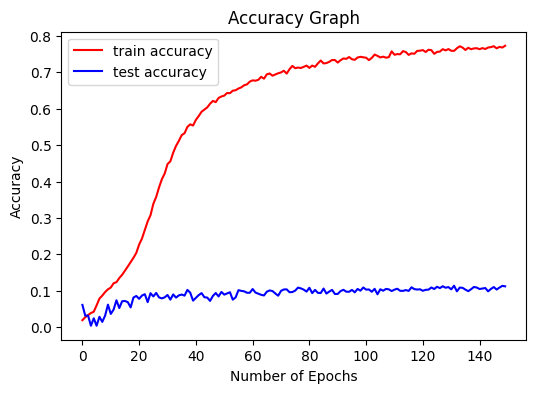

In [29]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [30]:
model.evaluate(X_test,y_test)

128/128 [==============================] - 1s 8ms/step - loss: 16.2054 - accuracy: 0.1123


[16.205434799194336, 0.11230995506048203]

In [31]:
model.save('model3_bi_lstm.h5')

In [32]:
lstm = load_model('model3_bi_lstm.h5')
lstm

In [33]:
def generate_text(model,tokenizer,sequence_len,seed_text,num_words):
    output_text = []
    input_text = seed_text
    
    for i in range(num_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        padded_text = pad_sequences([encoded_text],maxlen=sequence_len,truncating='pre')
        predictions = model.predict(padded_text,verbose=0)[0]
        pred_word = tokenizer.index_word[predictions.argmax()]
        input_text += ' ' + pred_word
        output_text.append(pred_word)
    
    return ' '.join(output_text)

In [34]:
for i in range(10):
    random_sequence = input_sequences[random.randint(0, len(input_sequences))]
    random_seed_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in random_sequence])
    print(f'{random_seed_text}: ')
    print(f'{generate_text(lstm, tokenizer, sequence_len, random_seed_text, num_words=25)}\n\n')

            for three score years: 
in a little town of dear frame thy light against the fine control young ones and flows and the snow white feet high right isle


             i looked behind: 
and i looked before with when i was arms on derry bubblin first another above my heart i heart my child of silence and time


              or when: 
i watched the small freebirds fly bright twould set your heart night of wind on today and no height night of going to know strife


             and many an: 
hours of grief shoulder and she locks of hair in the brand young thru young at bragh again to the way it i should have


           and thats why i smiled: 
on them all the day for her than god he to sit and maidens loth white groats above the side of side knowledge their sea


          when i watched she took from: 
a creole girl i courted taken by and i hear the sun or things to be cross to immortal places on my bubblin shaken died


           but where theres good claret: 
plying he sa

In [39]:
seed_text = "i looked behind"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

i looked behind and i looked before with when i was arms on derry bubblin first another above my heart i heart my child of silence and time


In [36]:
seed_text = "flower"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

flower his strewn host of men women and some of take today and young on on the weirs ones on the palms of one's hands— so


In [37]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

The world seems and got and always beware at your cursing sinking sinking sinking sinking sinking sinking sinking sinking sinking sinking sinking son can let you be


In [38]:
seed_text = "world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

world is other and other world is here and there is there were moving to be again irish ground night he was my last seen some


In [ ]:
# # Save the tokenizer
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Save the model
# model.save('model.h5')

# # Save training history
# with open('history.pickle', 'wb') as handle:
#     pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
# # Save training history
# with open('training_history_lstm.pickle', 'wb') as file:
#     pickle.dump(r.history, file)

# # ...........................

# # # Load the tokenizer
# # with open('tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)

# # # Load the model
# # model = load_model('model.h5')

# # # Load the history
# # with open('history.pickle', 'rb') as handle:
# #     history = pickle.load(handle)